# Salary Classification Prediction

Import Libraries

In [888]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Open Files

In [889]:
train = pd.read_csv('C:/Users/matth/Downloads/au_train.csv')
test = pd.read_csv('C:/Users/matth/Downloads/au_test.csv')
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess Data

Check for null values

In [890]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Rename "class" column to "salary"

In [891]:
train = train.rename(columns={'class': 'salary'})
test = test.rename(columns={'class': 'salary'})

Strip leading whitespace in object (string) columns

In [892]:
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)
test['salary'] = test['salary'].map(lambda x: x.rstrip('.'))

Count number of "?" in columns

In [893]:
train[train == '?'].count()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
salary               0
dtype: int64

In [894]:
test[test == '?'].count()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
salary              0
dtype: int64

Replace "?" values with "unknown"

In [895]:
train.replace(to_replace = '?', value = 'unknown', inplace = True)
train.isin(['?']).any(0)

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
salary            False
dtype: bool

In [896]:
test.replace(to_replace = '?', value = 'unknown', inplace = True)
test.isin(['?']).any(0)

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
salary            False
dtype: bool

One hot encode nominal columns

In [897]:
ohe = OneHotEncoder(sparse = False)
nominal_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ohe.fit_transform(train[nominal_cols])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [898]:
ohe.fit_transform(test[nominal_cols])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Convert all education levels below HS-grad into a single category

In [899]:
list(train['education'].unique())

['Bachelors',
 'HS-grad',
 '11th',
 'Masters',
 '9th',
 'Some-college',
 'Assoc-acdm',
 'Assoc-voc',
 '7th-8th',
 'Doctorate',
 'Prof-school',
 '5th-6th',
 '10th',
 '1st-4th',
 'Preschool',
 '12th']

In [900]:
train['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

In [901]:
train.replace(to_replace = ['Preschool','1st-4th','5th-6th','7th-8th', '9th', '10th', 
                           '11th', '12th'], value = 'Below-HS', inplace = True)
test.replace(to_replace = ['Preschool','1st-4th','5th-6th','7th-8th', '9th', '10th', 
                           '11th', '12th'], value = 'Below-HS', inplace = True)
train['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Below-HS         4253
Masters          1723
Assoc-voc        1382
Assoc-acdm       1067
Prof-school       576
Doctorate         413
Name: education, dtype: int64

Encode ordinal (education) column

In [902]:
education_categories = ['Below-HS', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 
                        'Bachelors', 'Masters', 'Prof-school', 'Doctorate']

oe = OrdinalEncoder(categories = [education_categories])

oe.fit_transform(train[['education']])
oe.fit_transform(test[['education']])

array([[0.],
       [1.],
       [4.],
       ...,
       [5.],
       [5.],
       [5.]])

In [903]:
column_transform = make_column_transformer((ohe, nominal_cols), (oe, ['education']))
column_transform.fit_transform(train)
column_transform.fit_transform(test)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 4.],
       ...,
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 5.]])

## Logistic Regression Model

Removed column "education-num" as it is redundant with the ordinal "education" column 

In [904]:
x_train = train.drop(['education-num', 'fnlwgt', 'salary'], axis=1)
y_train = train['salary']
x_test = test.drop(['education-num', 'fnlwgt', 'salary'], axis=1)
y_test = test['salary']

Create logistic regression model

logisticRegr = LogisticRegression(max_iter=400)
logisticRegr_pipeline = make_pipeline(column_transform, logisticRegr)
logisticRegr_pipeline.fit(x_train, y_train)

Fit test data to model

In [905]:
predictions = pd.Series(logisticRegr_pipeline.predict(x_test))

Create confusion matrix

[[11548  1802]
 [  887  2044]]


<AxesSubplot:>

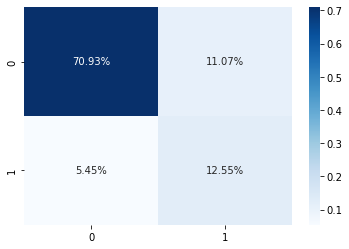

In [906]:
cm = metrics.confusion_matrix(predictions, y_test)
print(cm)

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

Create ROC Curve

In [907]:
def plot_roc_curve(true_y, y_prob):

    true_y = true_y.map({'>50K': 1, '<=50K': 0})
    y_prob = y_prob.map({'>50K': 1, '<=50K': 0})
    fpr, tpr, thresholds = metrics.roc_curve(true_y, y_prob)
    auc = metrics.roc_auc_score(true_y, y_prob)

    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

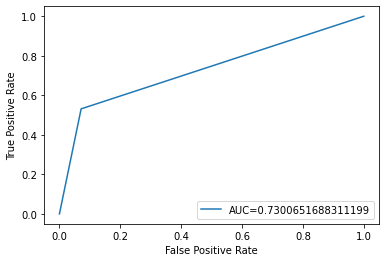

In [908]:
plot_roc_curve(y_test, predictions)

## Random Forest Model

Create Random Forest Model and fit test data to model

In [909]:
clf = RandomForestClassifier(n_estimators=100) 
clf_pipeline = make_pipeline(column_transform, clf)

clf_pipeline.fit(x_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf_pipeline.predict(x_test)
y_pred = pd.Series(y_pred)

 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.8245807997051778


Confusion Matrix for the model

[[11271  1692]
 [ 1164  2154]]


<AxesSubplot:>

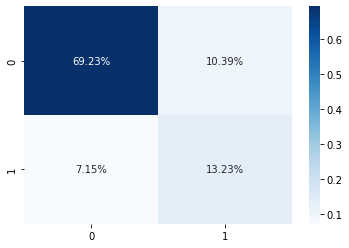

In [910]:
cm = metrics.confusion_matrix(y_pred, y_test)
print(cm)

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ROC curve for the model

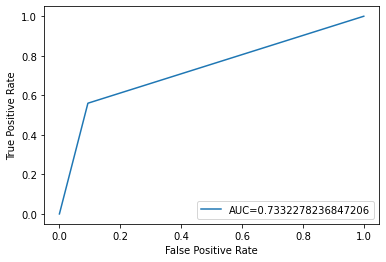

In [911]:
plot_roc_curve(y_test, y_pred)